# Project 1: Digit Classification with KNN and Naive Bayes

In this project,  you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sb
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import scipy.ndimage as ndimage
from sklearn.preprocessing import normalize

# Set the randomizer seed so results are the same each time.
np.random.seed(0)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [4]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 
#        53MB so this cell should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points 
# and apply this permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


data shape:  (70000, 784)
label shape: (70000,)


#### Sample Image
> First lets create an image to check how it would look like for number 6

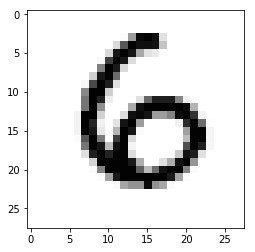

In [5]:
#We are using the label to identify the digit and then looking at the correspoonding X value

U = X[np.where(Y==6)]
plt.imshow(U[9].reshape(28,28), cmap = "Greys")

**(1)** Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

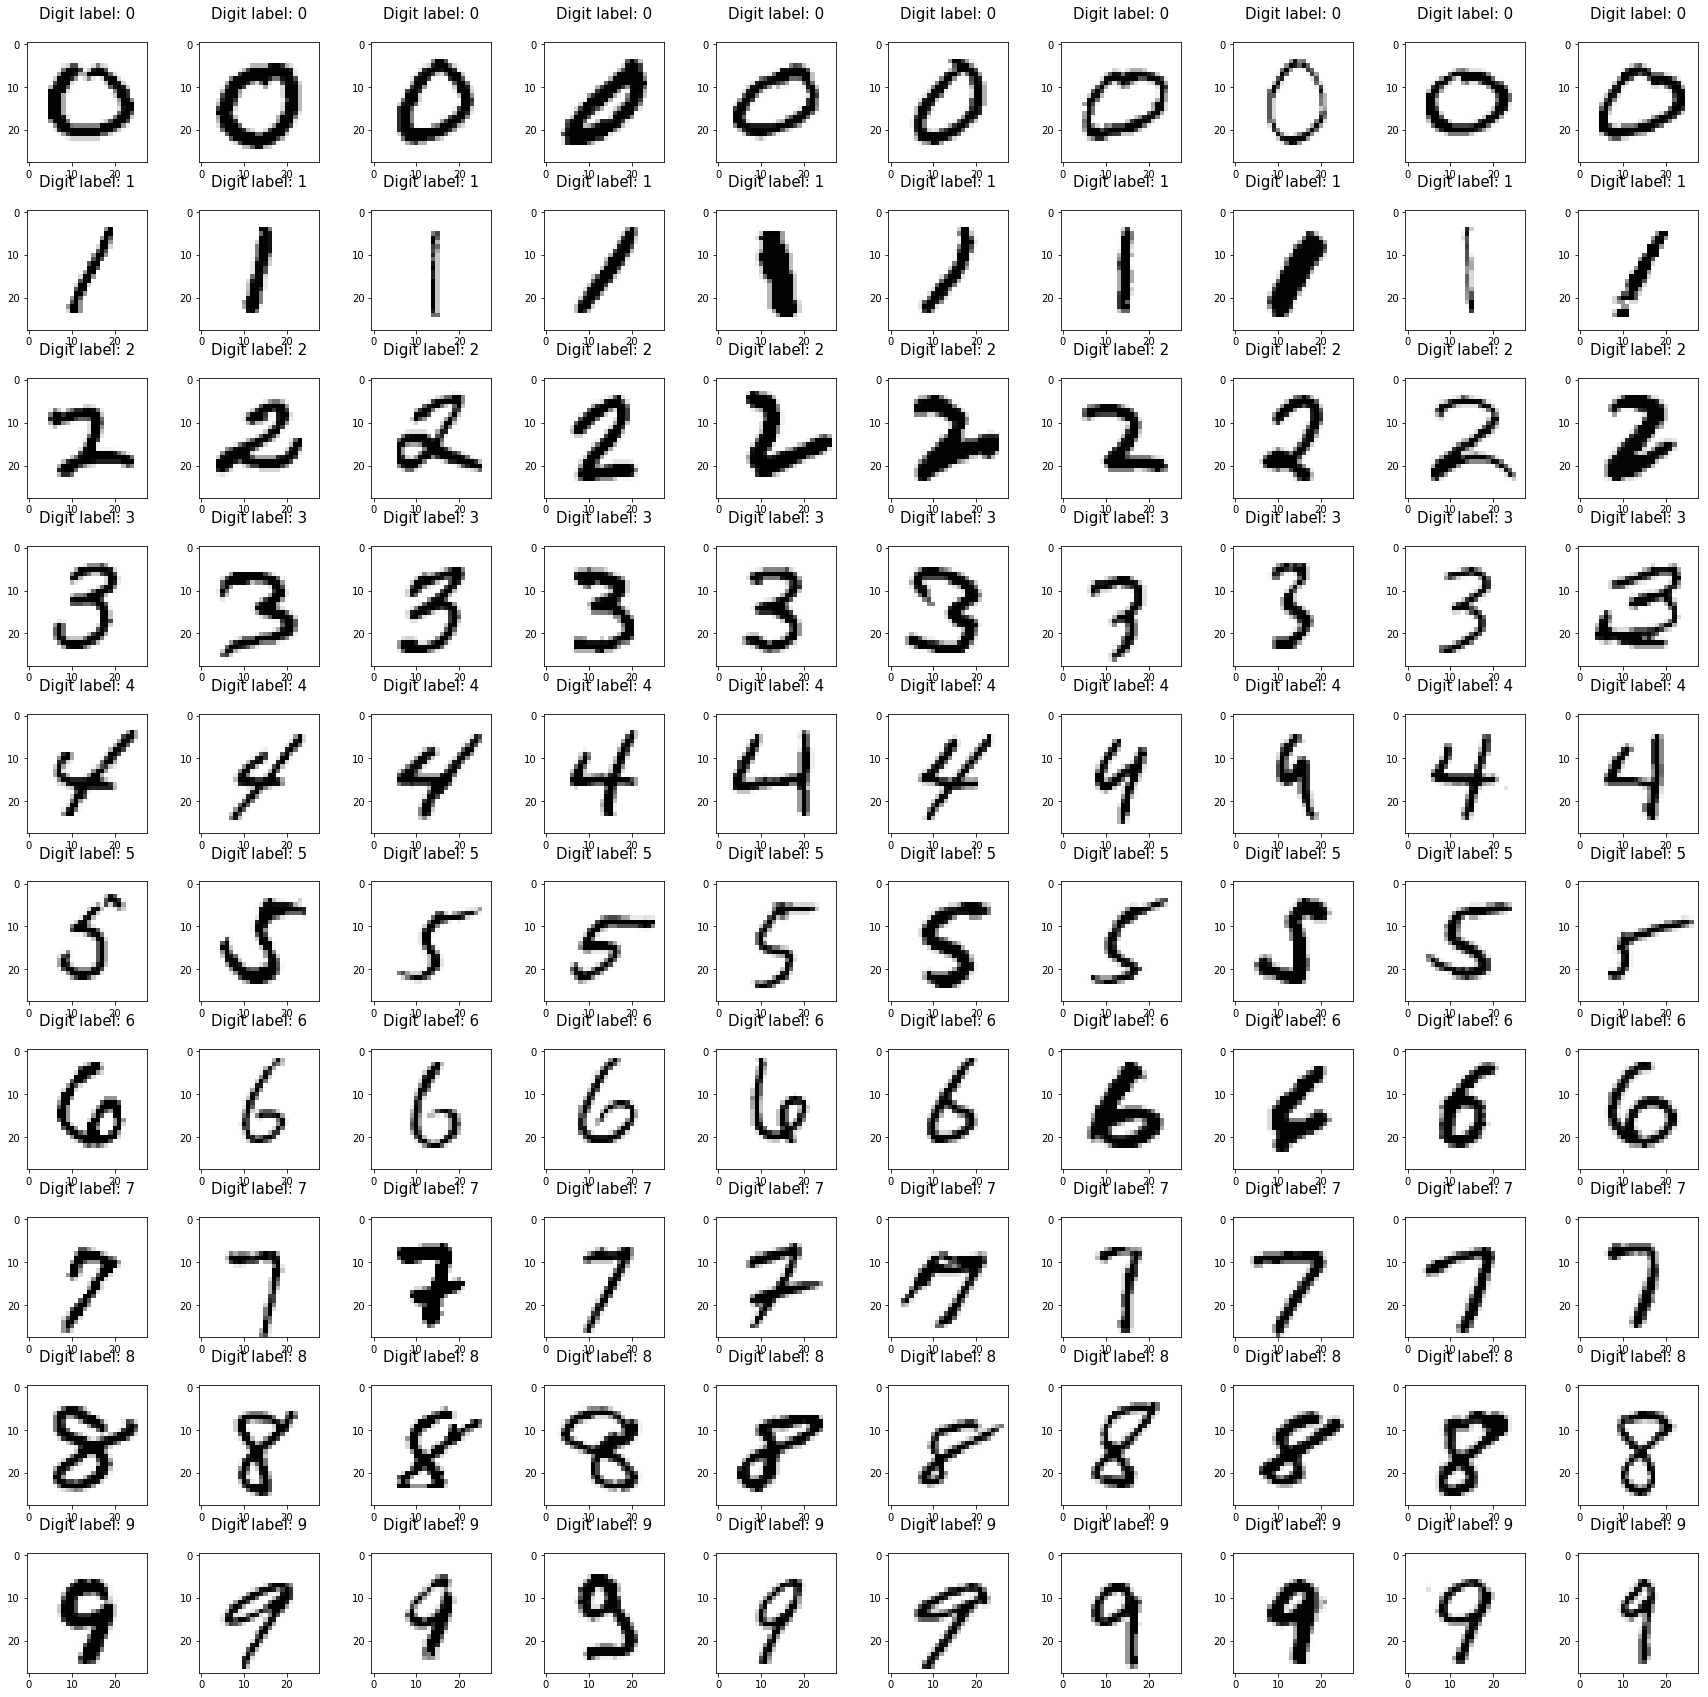

In [6]:
# This function takes in three arguments, the first one lists out the number of examples we would want to 
# display, second gives the pixel values, the third, the labeo for the image
def P1(num_examples, X, Y):
    plt.figure(figsize=(30,30))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Iterate through ten digits and then through a number of samples

    for i in np.arange(10):
        for j in np.arange(num_examples):
            M = X[np.where(Y==i)]
            K = M[j].reshape(28,28)
            plt.subplot(10,num_examples, j+1 + i*num_examples)
            plt.imshow(K, cmap = "Greys")
            plt.title('Digit label: %i\n' %i, fontsize = 15)


P1(10, X, Y)

**(2)** Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [7]:
#Function that takes the value of K, training data and test data. Returns the model and the error labels

def P2(k_value, train_data, train_labels, test_data, test_labels):
    model_raw = KNeighborsClassifier(n_neighbors=k_value)
    model_raw.fit(train_data, train_labels)
    print ("Model accuracy for K = " + str(k_value) + " is :" + str(model_raw.score(test_data, test_labels)))
    test_predict_labels = model_raw.predict(test_data)
    wrong_prediction = (test_predict_labels != test_labels)
    unique, counts = np.unique(test_labels[wrong_prediction],return_counts=True)
    error_labels = np.column_stack((unique, counts))
    return model_raw, error_labels

k_values = [1, 3, 5, 7, 9]
for i in range(np.size(k_values)):
    model, error_labels = P2(k_values[i], mini_train_data, mini_train_labels, dev_data, dev_labels)

# Next we want to look at the metris for K = 1

k_values=[1]
for i in range(np.size(k_values)):
    model, error_labels = P2(k_values[i], mini_train_data, mini_train_labels, dev_data, dev_labels)
    print ("\n" + '*** Confusion Matrix ***')
    print(confusion_matrix(dev_labels, model.predict(dev_data)))
    print("\n")
    print("*** Model Metrics ***")
    print(classification_report(dev_labels, model.predict(dev_data)))
    print("\n" + "number of incorrect predictions for K = "+ str(k_values[i]) + " is : \n" 
              + str(error_labels) + "\n" )


Model accuracy for K = 1 is :0.888
Model accuracy for K = 3 is :0.878
Model accuracy for K = 5 is :0.869
Model accuracy for K = 7 is :0.865
Model accuracy for K = 9 is :0.863
Model accuracy for K = 1 is :0.888

*** Confusion Matrix ***
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


*** Model Metrics ***
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        99
         1.0       0.89      1.00      0.94       105
         2.0       0.99      0.79      0.88       102
         3.0       0.77      0.87      0.82        86
         4.0       0.89      0.82     

**Answer:**
> Looks like **number 2** seems to have the lowest predictor. Looking at the confusion matrix, number 4 seems to be the most confused with number 9. This is understandable due to the fact 4 looks close to 9 in few sample images that we printed out.
<br>
> Model seems to be accurate at **K = 1**.

**(3)** Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [8]:
# Function P3 takes in the size of training samples to use and returns the accuracy while running a K-NN 
# classifier with K = 1
def P3(train_sizes, accuracies):

    for i in range(np.size(train_sizes)):
        current_time = time.ctime(int(time.time()))
        print (("start_time:") + str(current_time) + ("     For training size:") + str(train_sizes[i]))
        train_data, train_labels = X[:train_sizes[i]], Y[:train_sizes[i]]
        model_raw = KNeighborsClassifier(n_neighbors=1)
        model_raw.fit(train_data, train_labels)
        accuracies[i] = model_raw.score(dev_data, dev_labels)
        dev_predict_labels = model_raw.predict(dev_data)
        current_time = time.ctime(int(time.time()))
        print (("End_time:  ") + str(current_time) + ("     For training size:") + str(train_sizes[i]))
        wrong_prediction = (dev_predict_labels != dev_labels)
        unique, counts = np.unique(dev_labels[wrong_prediction],return_counts=True)
        error_labels = np.column_stack((unique, counts))
    return accuracies

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = np.zeros(np.size(train_sizes))
P3(train_sizes, accuracies)
print("\n")
for i in np.arange(len(train_sizes)):
    print ('TrainingSize = %.1f    Accuracy = %0.5f' %(train_sizes[i], accuracies[i]))

start_time:Mon Feb 11 10:59:33 2019     For training size:100
End_time:  Mon Feb 11 10:59:34 2019     For training size:100
start_time:Mon Feb 11 10:59:34 2019     For training size:200
End_time:  Mon Feb 11 10:59:34 2019     For training size:200
start_time:Mon Feb 11 10:59:34 2019     For training size:400
End_time:  Mon Feb 11 10:59:36 2019     For training size:400
start_time:Mon Feb 11 10:59:36 2019     For training size:800
End_time:  Mon Feb 11 10:59:39 2019     For training size:800
start_time:Mon Feb 11 10:59:39 2019     For training size:1600
End_time:  Mon Feb 11 10:59:45 2019     For training size:1600
start_time:Mon Feb 11 10:59:45 2019     For training size:3200
End_time:  Mon Feb 11 11:00:00 2019     For training size:3200
start_time:Mon Feb 11 11:00:00 2019     For training size:6400
End_time:  Mon Feb 11 11:00:27 2019     For training size:6400
start_time:Mon Feb 11 11:00:27 2019     For training size:12800
End_time:  Mon Feb 11 11:01:24 2019     For training size:1280

**Answer:**
- As expected the time taken for training the model increases as the sample size increases. The model accuracy increases as well as the size of the training data increases. Even with a simple 1NN classifier we are seeing close to 97% accuracy.

**(4)** Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [9]:
# This function takes in the training sizes and returns the predicted value for X = 62000 while running a 
# linear regression model
def P4(train_sizes):
    for i in range(np.size(train_sizes)):
        train_data, train_labels = X[:train_sizes[i]], Y[:train_sizes[i]]
        model_raw = LinearRegression()
        model_raw.fit(train_data, train_labels)
        N = model_raw.predict(X[62000].reshape(1, -1))
        print ('Thre prediction of 8 is:', N) 
    return 
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = np.zeros(np.size(train_sizes))
P4(train_sizes)


Thre prediction of 8 is: [7.36446286]
Thre prediction of 8 is: [7.75622936]
Thre prediction of 8 is: [-2.31067587]
Thre prediction of 8 is: [1.474259]
Thre prediction of 8 is: [5.6133583]
Thre prediction of 8 is: [5.89670358]
Thre prediction of 8 is: [5.91513553]
Thre prediction of 8 is: [6.34676343]
Thre prediction of 8 is: [6.19562804]


**ANSWER:**
> Even with different training sizes, the prediction is very poor. We might have to look at using Logistic Regression over here rather than traditional Linear Regression

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Model accuracy for K = 1 is :0.888


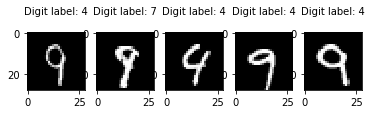

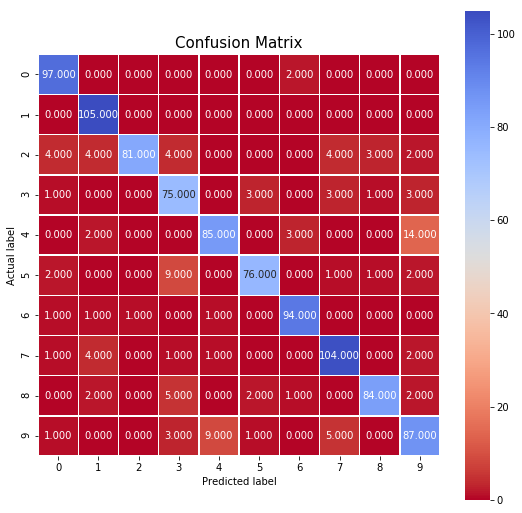

In [10]:
# Function P5 returns the 
def P5(k_values):
    index = 0
    misclassifiedIndexes = []
    model, error_labels  = P2(k_values[0], mini_train_data, mini_train_labels, dev_data, dev_labels)
    predict_labels = model.predict(dev_data)
    for label, predict in zip(dev_labels, predict_labels):
        if label != predict and label == 9 : 
            misclassifiedIndexes.append(index)
        index +=1
    for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
        plt.subplot(1, 5, plotIndex + 1)
        plt.imshow(np.reshape(dev_data[badIndex], (28,28)), cmap=plt.cm.gray)
        plt.title('Digit label: %i\n' %predict_labels[badIndex], fontsize = 10)
    plt.figure(figsize=(9,9))
    sb.heatmap(confusion_matrix(dev_labels, model.predict(dev_data)), annot=True, fmt=".3f", linewidths=.5, 
           square = True, cmap = 'coolwarm_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Confusion Matrix'
    plt.title(all_sample_title, size = 15)

k_values = [1]
P5(k_values)



(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Model accuracy for K = 1 is :0.909
Model accuracy for K = 1 is :0.871
Model accuracy for K = 1 is :0.903


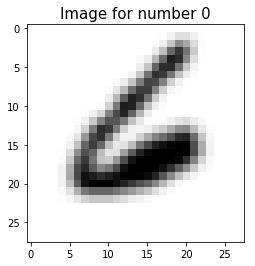

In [11]:
def P6(X):
    P = X.reshape(X.shape[0],28,28)
    N = np.zeros((P.shape[0],30,30), dtype='float64')
    N[:,1:-1, 1:-1] = P[:,:,:]
    N[:, 1:-1,1:-1] = (1/9.0)*(N[:, 0:-2, :-2] + N[:, 0:-2,1:-1] + N[:, 0:-2,2:] +
                           N[:,1:-1, 0:-2]   + N[:,1:-1,1:-1] + N[:,1:-1,2:] +
                           N[:,2:  , 0:-2] + N[:,2:  ,1:-1] + N[:,2:  ,2:])
    Q = N[:, 1:-1, 1:-1]
    M = Q.reshape(P.shape[0], -1) 
    plt.imshow(M[10].reshape(28,28), cmap = "Greys")
    plt.title("Image for number 0", size = 15)
    return M

k_values = [1]
model_1, error_labels_1 = P2(k_values[0], P6(mini_train_data), mini_train_labels, 
                             dev_data, dev_labels)
model_2, error_labels_2 = P2(k_values[0], mini_train_data, mini_train_labels, P6(dev_data), dev_labels)
model_3, error_labels_3  = P2(k_values[0], P6(mini_train_data), mini_train_labels, P6(dev_data), dev_labels)


**ANSWER:**
> The accuracy has increased by 3 percent when we used smoothing for both training and development data. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

Model accuracy for Binomial NB is = 0.815


*** Model Metrics for Bernoulli Naive Bayes Model ***
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        99
         1.0       0.86      0.96      0.91       105
         2.0       0.87      0.78      0.82       102
         3.0       0.63      0.74      0.68        86
         4.0       0.89      0.78      0.83       104
         5.0       0.81      0.63      0.71        91
         6.0       0.87      0.89      0.88        98
         7.0       0.91      0.76      0.83       113
         8.0       0.74      0.77      0.76        96
         9.0       0.72      0.84      0.77       106

   micro avg       0.81      0.81      0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000


number of incorrect predictions for Bernoulli Naive Bayes Model are : 
[[ 0.  3.]
 [ 1.  4.]
 [ 2. 22.]
 [ 3. 22.]
 [ 4. 23.]
 [ 5. 34.]
 [ 6.

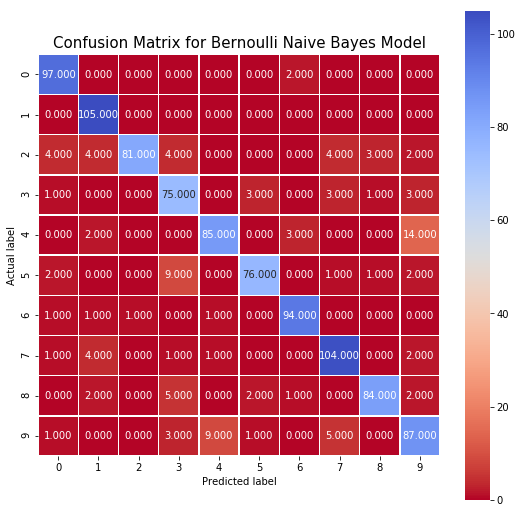

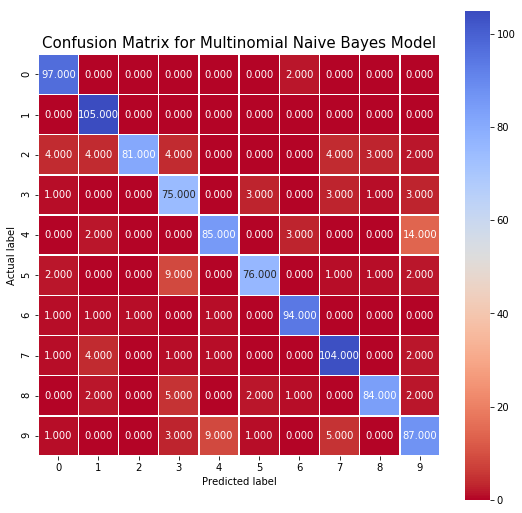

In [12]:
# This function takes training, test data and alpha as input parameters and returns the fitted Bernoulli model
# and the error count for each label as the output. The threshold used to binarize is 0.0, so any pixel with value 
# greater than zero is set to 1
def P7_BernoulliNB(train_data, train_labels, test_data, test_labels, alphas):
    model = BernoulliNB(alpha = alphas, binarize=0.0)
    model.fit(train_data, train_labels)
    print ("Model accuracy for Binomial NB is = " + str(model.score(test_data, test_labels)))
    test_predict_labels = model.predict(test_data)
    wrong_prediction = (test_predict_labels != test_labels)
    unique, counts = np.unique(test_labels[wrong_prediction],return_counts=True)
    error_labels = np.column_stack((unique, counts))
    return model, error_labels

# This function takes training and  test data as input parameters and returns the fitted Multinomial model
# and the error count for each label as the output
def P7_MultinomialNB(train_data, train_labels, test_data, test_labels):
    model = MultinomialNB()
    model.fit(train_data, train_labels)
    print ("Model accuracy for Multinomial NB is = " + str(model.score(test_data, test_labels)))
    test_predict_labels = model.predict(test_data)
    wrong_prediction = (test_predict_labels != test_labels)
    unique, counts = np.unique(test_labels[wrong_prediction],return_counts=True)
    error_labels = np.column_stack((unique, counts))
    return model, error_labels

#This function takes a dataset and returns a mapped value for the dataset with three buckets 0,1 and 2
def P7_map(dataset):
    new_dataset = dataset
    new_dataset = np.where(new_dataset[:]==0.0,0.0, new_dataset[:])
    new_dataset = np.where((new_dataset[:]>0.0) & (new_dataset[:] < 1.0), 1, new_dataset[:])
    new_dataset = np.where(new_dataset[:]== 1.0, 2, new_dataset[:])
    return new_dataset
    
alphas = 1.0    
model_1, error_labels = P7_BernoulliNB(mini_train_data, mini_train_labels, dev_data, dev_labels, alphas )
print ("\n")
plt.figure(figsize=(9,9))
sb.heatmap(confusion_matrix(dev_labels, model.predict(dev_data)), annot=True, fmt=".3f", linewidths=.5, 
           square = True, cmap = 'coolwarm_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix for Bernoulli Naive Bayes Model'
plt.title(all_sample_title, size = 15)
print("*** Model Metrics for Bernoulli Naive Bayes Model ***")
print(classification_report(dev_labels, model_1.predict(dev_data)))
print("\n" + "number of incorrect predictions for Bernoulli Naive Bayes Model are : \n" 
              + str(error_labels) + "\n" )
model_2, error_labels = P7_MultinomialNB(P7_map(mini_train_data), mini_train_labels, P7_map(dev_data), dev_labels)
print ("\n")
plt.figure(figsize=(9,9))
sb.heatmap(confusion_matrix(dev_labels, model.predict(dev_data)), annot=True, fmt=".3f", linewidths=.5, 
           square = True, cmap = 'coolwarm_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix for Multinomial Naive Bayes Model'
plt.title(all_sample_title, size = 15)
print("*** Model Metrics for Multinomial Naive Bayes Model ***")
print(classification_report(dev_labels, model_2.predict(dev_data)))
print("\n" + "number of incorrect predictions for Multinomial Naive Bayes Model are : \n" 
              + str(error_labels) + "\n" )

ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [13]:
# This function returns the best parameters for a given set of alphase for our training data
def P8(alphas):
    bnb = BernoulliNB(binarize=0.0)
    bnb.fit(mini_train_data, mini_train_labels)
    gcv = GridSearchCV(bnb, param_grid = alphas, n_jobs=-1)
    gcv.fit(mini_train_data, mini_train_labels)
    print('Best score:', gcv.best_score_)
    print('Best parameters:', gcv.best_params_)
    return
    
    


alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best score: 0.821
Best parameters: {'alpha': 0.1}


/Users/sniggie/Desktop/conda/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**ANSWER:**
- Alpha = 0.1 proves better prediction from the list of alphas we provided.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [14]:
# Funtion takes training and test data as the inputs and fit a Gaussian 
# Naive Bayes model

def P9_GaussianNB(train_data, train_labels, test_data, test_labels):
    GaussianNB_model = GaussianNB(priors=None)
    GaussianNB_model.fit(train_data, train_labels)
    print ("Model accuracy for Gaussian NB is = " + str(GaussianNB_model.score(test_data, test_labels)))
    test_predict_labels = GaussianNB_model.predict(test_data)
    wrong_prediction = (test_predict_labels != test_labels)
    unique, counts = np.unique(test_labels[wrong_prediction],return_counts=True)
    error_labels = np.column_stack((unique, counts))
    print ('Sigma Value is: ', '\n' , GaussianNB_model.sigma_)
    print ('Theta Value is: ', '\n'  , GaussianNB_model.theta_)
    return GaussianNB_model, error_labels

# Funtion takes training, test data and smoothing parameter as the inputs and fit a Gaussian 
# Naive Bayes model
def P9_GaussianNB_improved(train_data, train_labels, test_data, test_labels, smoothing):
    GaussianNB_model = GaussianNB(priors=None,var_smoothing=smoothing)
    GaussianNB_model.fit(train_data, train_labels)
    print ("Model accuracy for Gaussian NB is = " + str(GaussianNB_model.score(test_data, test_labels)))
    test_predict_labels = GaussianNB_model.predict(test_data)
    wrong_prediction = (test_predict_labels != test_labels)
    unique, counts = np.unique(test_labels[wrong_prediction],return_counts=True)
    error_labels = np.column_stack((unique, counts))
    return GaussianNB_model, error_labels

model_3, error_labels = P9_GaussianNB(mini_train_data, mini_train_labels, dev_data, dev_labels)
print ("\n" + '*** Confusion Matrix ***')
print(confusion_matrix(dev_labels, model_3.predict(dev_data)))
print("\n")
print("*** Model Metrics ***")
print(classification_report(dev_labels, model_3.predict(dev_data)))
print("\n" + "number of incorrect predictions is : \n" 
              + str(error_labels) + "\n" )

model_4, error_labels_4 = P9_GaussianNB_improved(mini_train_data, mini_train_labels, dev_data, dev_labels, 0.1)
print ("\n" + '*** Confusion Matrix ***')
print(confusion_matrix(dev_labels, model_4.predict(dev_data)))
print("\n")
print("*** Model Metrics ***")
print(classification_report(dev_labels, model_4.predict(dev_data)))
print("\n" + "number of incorrect predictions is : \n" 
              + str(error_labels_4) + "\n" )

Model accuracy for Gaussian NB is = 0.621
Sigma Value is:  
 [[1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]
 [1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]
 [1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]
 ...
 [1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]
 [1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]
 [1.98697608e-10 1.98697608e-10 1.98697608e-10 ... 1.98697608e-10
  1.98697608e-10 1.98697608e-10]]
Theta Value is:  
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

*** Confusion Matrix ***
[[83  0  3  1  2  6  3  0  1  0]
 [ 0 93  0  1  0  3  2  0  4  2]
 [ 6  2 40 11  2  1 16  1 20  3]
 [ 1  2  5 39  0  3  7  0 21  8]
 [ 4  

**ANSWER:**
> The accuracy of the Gaussian Naive Bayes model is relatively low. On further examining the attributes theta and Sigma we find that the features are not normally distributed which is one of the tenets for using Gaussian NB.
To fix this, we can try to normalize the features and then rerun the model to check for accuracy. When we smoothen the variance, we see that the accuracy is pretty close to Bernoulli Naive Bayes



(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

Model accuracy for Binomial NB is = 0.816


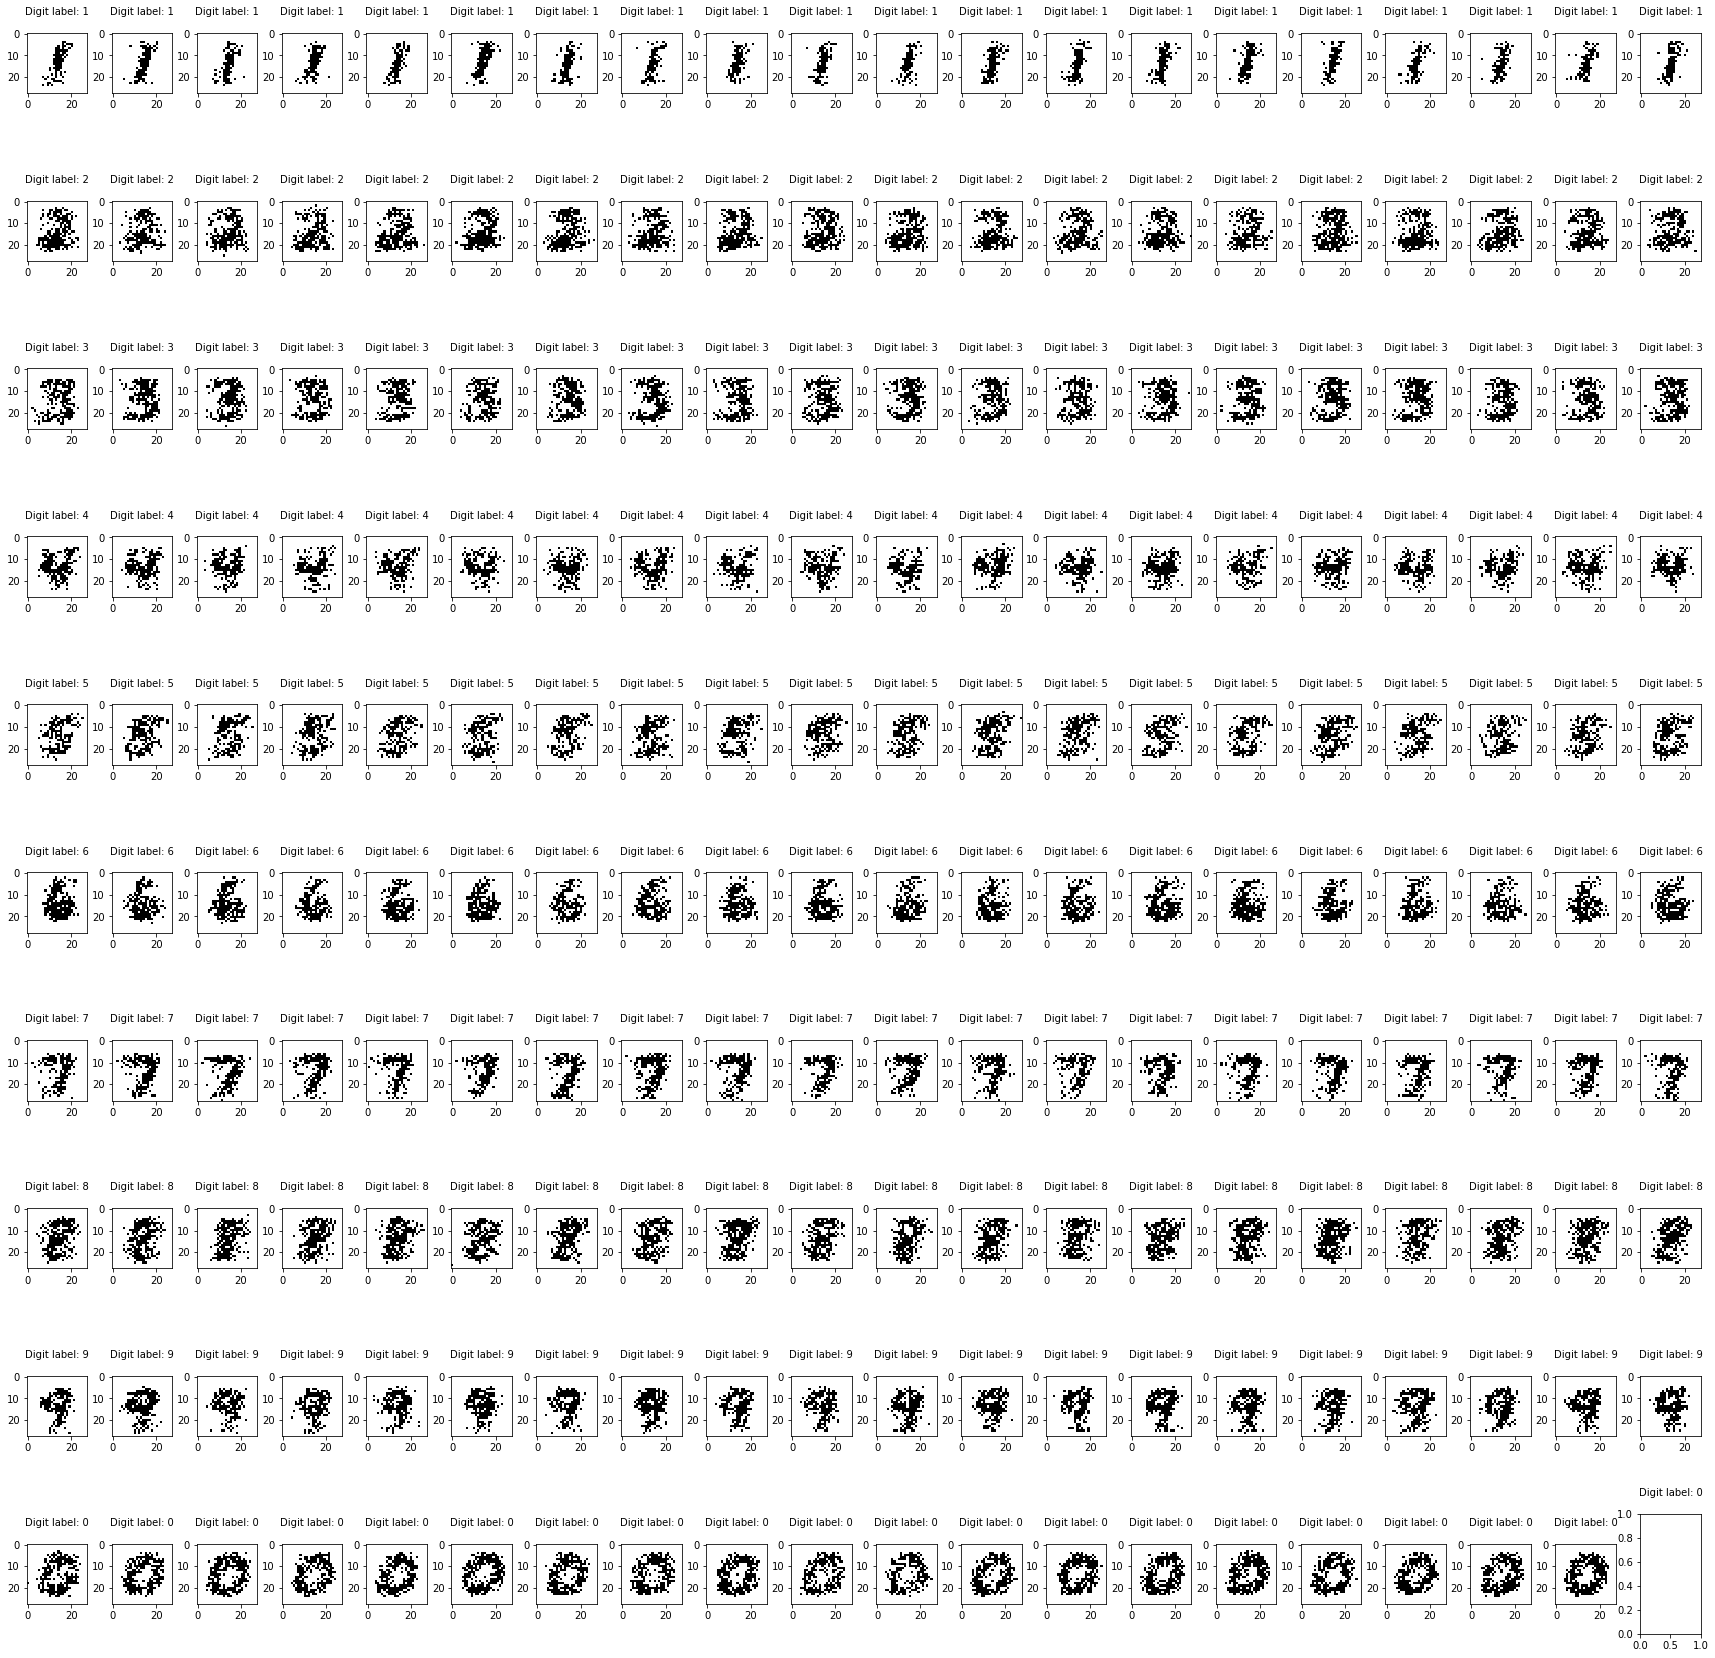

In [20]:
def P10(num_examples):
    model_BNB, error_label_BNB = P7_BernoulliNB(mini_train_data, mini_train_labels, dev_data, dev_labels, 0.01)
    plt.figure(figsize=(30,30))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in np.arange(20):
        K = np.random.binomial(1,np.exp(model_BNB.feature_log_prob_))
        for j in np.arange(10):
            plt.imshow(K[j].reshape(28,28), cmap = "Greys")
            plt.subplot(10,20, i + 20*j+1)
            plt.title('Digit label: %i\n' %((j+1)%10), fontsize = 10)

P10(20)

**ANSWER:** 
> We can see that the model does a pretty decent job of generating back the sample data. This would not be possible with discriminative models. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [16]:
def P11(buckets, correct, total):
    posterior_prob = np.zeros((1000,1), dtype='float64')
    posterior_prob_classes = np.zeros((1000,1), dtype='float64')
    model_BNB, error_label_BNB = P7_BernoulliNB(mini_train_data, mini_train_labels, dev_data, dev_labels, 0.01)
    posterior_prob_classes = model_BNB.predict_proba(dev_data)
    dev_predict_labels = model_BNB.predict(dev_data)
    correct_prediction = (dev_predict_labels == dev_labels)
    posterior_prob = np.max(posterior_prob_classes, axis=1)
    print (posterior_prob_classes)
    bins = np.digitize(posterior_prob[:],buckets)
    predict_vector = np.column_stack((correct_prediction, bins))
    for i in range(len(buckets)):
        correct[i] = np.sum(np.where((predict_vector[:,0] == 1) & (predict_vector[:,1] == i+1), True, False))
        total[i] = np.sum(np.where(predict_vector[:,1] == i+1, True, False))
    return correct, total

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

correct, total = P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = float(correct[i]) / total[i]
    print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

Model accuracy for Binomial NB is = 0.816
[[3.49057907e-079 4.25943947e-086 3.57108985e-054 ... 2.39649098e-028
  1.00893222e-037 3.55887643e-006]
 [6.40092775e-049 2.79300426e-151 1.96226302e-049 ... 1.46037742e-098
  9.14204638e-057 4.85037469e-107]
 [4.80257737e-088 4.03220993e-135 2.96865450e-044 ... 1.18423904e-114
  2.33895108e-084 6.30732643e-091]
 ...
 [1.00000000e+000 4.52789313e-307 1.41372874e-079 ... 4.92452665e-177
  3.95491935e-089 9.04540204e-161]
 [5.98334832e-094 1.00000000e+000 6.01438521e-047 ... 4.71854196e-099
  1.23690117e-038 2.00183477e-094]
 [1.00000000e+000 0.00000000e+000 1.96504292e-111 ... 1.38309902e-257
  8.94358624e-098 4.04936827e-255]]
p(pred) <= 0.5000000000000    total =  30    accuracy = 0.400
p(pred) <= 0.9000000000000    total =  76    accuracy = 0.447
p(pred) <= 0.9990000000000    total =  51    accuracy = 0.490
p(pred) <= 0.9999900000000    total =  62    accuracy = 0.581
p(pred) <= 0.9999999000000    total =  44    accuracy = 0.591
p(pred) <= 0

**ANSWER:**

> The model is calibrated, based on the data we see from the Posterior Probabilities and the accuracy.


(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

Model accuracy for Binomial NB is = 0.818


NameError: name 'P9_GaussianNB_improved' is not defined

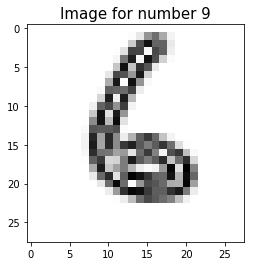

In [27]:
def P12_sobel(X):
    P = X.reshape(X.shape[0],28,28)
    NX = np.zeros((P.shape[0],30,30), dtype='float64')
    NX[:,1:-1, 1:-1] = P[:,:,:]
    NX[:, 1:-1,1:-1] = (-1.0*NX[:, 0:-2, :-2] + 0.0*NX[:, 0:-2,1:-1] + 1.0*NX[:, 0:-2,2:] +
                           -2.0*NX[:,1:-1, 0:-2]   + 0.0*NX[:,1:-1,1:-1] + 2.0*NX[:,1:-1,2:] +
                           -1.0*NX[:,2:  , 0:-2] + 0.0*NX[:,2:  ,1:-1] + 1.0*NX[:,2:  ,2:])
    NY = np.zeros((P.shape[0],30,30), dtype='float64')
    NY[:,1:-1, 1:-1] = P[:,:,:]
    NY[:, 1:-1,1:-1] = (-1.0*NY[:, 0:-2, :-2] + -2.0*NY[:, 0:-2,1:-1] + -1.0*NY[:, 0:-2,2:] +
                           0.0*NY[:,1:-1, 0:-2]   + 0.0*NY[:,1:-1,1:-1] + 0.0*NY[:,1:-1,2:] +
                           1.0*NY[:,2:  , 0:-2] + 2.0*NY[:,2:  ,1:-1] + 1.0*NY[:,2:  ,2:])
    #This helps determine the edges using solbel filter
    Q = np.sqrt(np.square(NX[:, 1:-1, 1:-1])+np.square(NY[:, 1:-1, 1:-1]))
    # This would give us the direction of the gradient for a sobel filter
    R = np.arctan(NY[:, 1:-1, 1:-1],NX[:, 1:-1, 1:-1])
    M = np.concatenate((Q.reshape(P.shape[0], -1), R.reshape(P.shape[0],-1), X), axis = 1)
    plt.imshow(M[2][:784].reshape(28,28), cmap = "Greys")
    plt.title("Image for number 9", size = 15)
    return M

model_3, error_labels_3  = P7_BernoulliNB(P12_sobel(mini_train_data), mini_train_labels, P12_sobel(dev_data), dev_labels, 0.01)
model_4, error_labels_4  = P9_GaussianNB_improved(P12_sobel(mini_train_data), mini_train_labels, P12_sobel(dev_data), dev_labels, 0.1)


**Answer:**
> Next I tried to better identify the edges and the gradient direction and added those to the features set for the image. This was done by using the below Kernels for Convolution. 
Gradient in X diretion is:
$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

> Gradient in Y direction is:
$$\begin{bmatrix} -1 & -2 & 1 \\ 0 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$
